In [1]:
import netCDF4
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

In [4]:
nc_path = '../../20220101000000-P1S-ABOM_OBS_B01-PRJ_GEOS141_1000-HIMAWARI8-AHI.nc'
nc = netCDF4.Dataset(nc_path)

# You can then list all the field names using nc.variables.keys()
for k in nc.variables.keys():
    print(k)

channel_0001_scaled_radiance
geostationary
scan_line_time
time
x
y


In [5]:
nc.variables['channel_0001_scaled_radiance'][0,1000:2000,1000:2000].data

array([[ 1.000000e+20,  1.000000e+20,  1.000000e+20, ..., -0.000000e+00,
        -0.000000e+00, -0.000000e+00],
       [ 1.000000e+20,  1.000000e+20,  1.000000e+20, ..., -0.000000e+00,
        -0.000000e+00, -0.000000e+00],
       [ 1.000000e+20,  1.000000e+20,  1.000000e+20, ..., -0.000000e+00,
        -0.000000e+00, -0.000000e+00],
       ...,
       [-0.000000e+00, -0.000000e+00, -9.765625e-04, ..., -0.000000e+00,
        -0.000000e+00, -0.000000e+00],
       [-9.765625e-04, -0.000000e+00, -0.000000e+00, ...,  9.765625e-04,
         9.765625e-04, -0.000000e+00],
       [-0.000000e+00, -0.000000e+00,  9.765625e-04, ..., -0.000000e+00,
         9.765625e-04, -9.765625e-04]], dtype=float32)

In [6]:
# takes every second cell
nc.variables['channel_0001_scaled_radiance'][0,::2,::2].data

array([[1.e+20, 1.e+20, 1.e+20, ..., 1.e+20, 1.e+20, 1.e+20],
       [1.e+20, 1.e+20, 1.e+20, ..., 1.e+20, 1.e+20, 1.e+20],
       [1.e+20, 1.e+20, 1.e+20, ..., 1.e+20, 1.e+20, 1.e+20],
       ...,
       [1.e+20, 1.e+20, 1.e+20, ..., 1.e+20, 1.e+20, 1.e+20],
       [1.e+20, 1.e+20, 1.e+20, ..., 1.e+20, 1.e+20, 1.e+20],
       [1.e+20, 1.e+20, 1.e+20, ..., 1.e+20, 1.e+20, 1.e+20]],
      dtype=float32)

# Some notes on datasets

There are three main datasets:
- Himawari 8
- MODIS
- VIIRS

For all three, the raw datasets can be a bit messy and require some preprocessings before we can do analysis, which is why Jeremy has provided us with the cleaner versions (for 2019-2020) in Cloudstor. Below I provide some notes about those Cloudstor files

### H8_MODIS_2019-2020
- This is Himawari 8 (H8) data which has been spatiotemporally matched with MODIS, i.e. one row per lat/long per day 
- Its x/y (from raw dataset) have also been mapped to lat/long. This process is complicated, and it involves replicating Jeremy's 'sample coordinate mapping script' that he sent to us. We don't have to do this for the time being.
- This dataset has the channel readings which should form as the *predictors* for our training and validation data
- It has MOD (Terra) and MYD (Aqua) data which have same fields but different time. We can use both in training, they'll just be separate training rows.
- It also has 2 resolutions: L2 and 3K. We should only choose one to begin with. I'd suggest L2 (for now, as a start) - lower resolution probably means quicker training time.

### MODIS_L2_Aus_2019-2020
- This is the AOD data from MODIS, i.e. one AOD reading per lat/long per day
- The most important field is `AOD_550_Dark_Target_Deep_Blue_Combined`. This should be the *response* in our model.
- We need to find a way to join this dataset with the H8_MODIS dataset. I believe this is done by joining on lat/long, but *let's confirm with Jeremy*.
- We also need to find a way to combine readings from multiple days so our training data can be expanded

### VIIRS_L2_Aus_2019-2020
- This is the VIIRS data, which to be honest I'm slightly unsure about
- I'm not sure how we should use it in combination with H8 and MODIS, so *let's ask Jeremy about this*.

# Some netCDF4 sample codes

In [7]:
# We read .nc files by using netCDF4.Dataset
nc_path = '../../H8_MODIS_2019-2020/H8_MOD04_L2/H8_MOD04_L2_Aus_0.05_2019-01-01.nc'
nc = netCDF4.Dataset(nc_path)

# You can then list all the field names using nc.variables.keys()
for k in nc.variables.keys():
    print(k)

lat
lon
time
solar_azimuth_angle
solar_zenith_angle
channel_0001_brf
channel_0001_scaled_radiance
channel_0002_brf
channel_0002_scaled_radiance
channel_0003_brf
channel_0003_scaled_radiance
channel_0004_brf
channel_0004_scaled_radiance
channel_0005_brf
channel_0005_scaled_radiance
channel_0006_brf
channel_0006_scaled_radiance
channel_0007_brightness_temperature
channel_0008_brightness_temperature
channel_0009_brightness_temperature
channel_0010_brightness_temperature
channel_0011_brightness_temperature
channel_0012_brightness_temperature
channel_0013_brightness_temperature
channel_0014_brightness_temperature
channel_0015_brightness_temperature
channel_0016_brightness_temperature


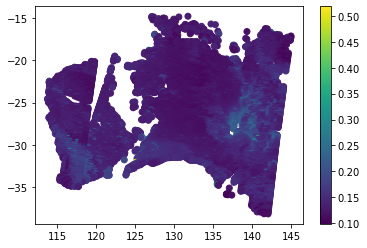

In [154]:
# Each field can be thought of as a numpy array, and to access it you do something like nc['variable name'][:].data
# For example, below code generates a plot using 3 fields: lat, lon, and channel_0001_brf
plt.scatter(nc['lon'][:].data, nc['lat'][:].data, c=nc['channel_0001_brf'][:].data)
plt.colorbar()
plt.show()

In [9]:
# You can also load these numpy arrays into a pandas DataFrame
pd.DataFrame({'lat':nc['lat'][:].data, 
              'lon':nc['lon'][:].data, 
              'channel_0001_brf':nc['channel_0001_brf'][:].data})

,lat,lon,channel_0001_brf
0,-14.753107,131.765823,0.130859
1,-16.210176,141.704361,0.133789
2,-16.236547,141.939377,0.141602
3,-16.299374,141.688354,0.120117
4,-16.325727,141.923538,0.125977
...,...,...,...
19535,-34.833126,116.778534,0.130859
19536,-34.876858,117.716774,0.151367
19537,-34.921795,116.768845,0.125977
19538,-34.943634,117.220055,0.150391


In [10]:
# we might also consider using the xarray package which can make life easier
import xarray as xr

ds = xr.open_dataset(nc_path)
df = ds.to_dataframe()
df

,lat,lon,time,solar_azimuth_angle,solar_zenith_angle,channel_0001_brf,channel_0001_scaled_radiance,channel_0002_brf,channel_0002_scaled_radiance,channel_0003_brf,...,channel_0007_brightness_temperature,channel_0008_brightness_temperature,channel_0009_brightness_temperature,channel_0010_brightness_temperature,channel_0011_brightness_temperature,channel_0012_brightness_temperature,channel_0013_brightness_temperature,channel_0014_brightness_temperature,channel_0015_brightness_temperature,channel_0016_brightness_temperature
sounding,,,,,,,,,,,,,,,,,,,,,
0,-14.753107,131.765823,2019-01-01 01:20:00,111.947266,27.097656,0.130859,0.120117,0.115234,0.105469,0.112305,...,310.2500,235.7500,245.9375,257.2500,297.9375,278.1875,300.3125,297.9375,291.9375,276.4375
1,-16.210176,141.704361,2019-01-01 01:20:00,115.446289,17.688477,0.133789,0.131836,0.115234,0.113281,0.126953,...,308.7500,236.6875,245.8125,256.5625,294.9375,276.7500,297.0000,294.3125,288.1250,273.9375
2,-16.236547,141.939377,2019-01-01 01:20:00,115.623047,17.483398,0.141602,0.139648,0.127930,0.125977,0.127930,...,312.1250,237.6250,246.3125,256.6875,294.1250,276.5625,296.3125,293.4375,287.1875,273.5000
3,-16.299374,141.688354,2019-01-01 01:20:00,115.153320,17.663086,0.120117,0.119141,0.105469,0.104492,0.103516,...,312.1250,237.0000,245.9375,256.6875,298.1250,279.7500,300.4375,297.6250,290.8750,275.6875
4,-16.325727,141.923538,2019-01-01 01:20:00,115.327148,17.458008,0.125977,0.124023,0.112305,0.110352,0.109375,...,315.2500,237.7500,246.5625,256.9375,298.8750,280.3125,301.2500,298.0000,290.8750,275.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19535,-34.833126,116.778534,2019-01-01 03:05:00,55.775391,18.876953,0.130859,0.127930,0.106445,0.104492,0.063477,...,297.1875,236.5625,246.1250,256.5625,287.2500,262.3125,289.6875,288.5625,284.6250,268.3750
19536,-34.876858,117.716774,2019-01-01 03:05:00,53.847656,18.266602,0.151367,0.148438,0.133789,0.130859,0.148438,...,317.8750,238.2500,249.1250,260.6250,304.8125,273.5625,308.0000,306.1250,299.3750,277.1875
19537,-34.921795,116.768845,2019-01-01 03:05:00,55.595703,18.918945,0.125977,0.123047,0.102539,0.100586,0.080078,...,307.4375,237.6250,248.0000,259.3125,297.3750,268.6875,300.1250,298.7500,293.6250,274.5000


# Himawari 8 - H8_MOD04_L2

lat
lon
time
solar_azimuth_angle
solar_zenith_angle
channel_0001_brf
channel_0001_scaled_radiance
channel_0002_brf
channel_0002_scaled_radiance
channel_0003_brf
channel_0003_scaled_radiance
channel_0004_brf
channel_0004_scaled_radiance
channel_0005_brf
channel_0005_scaled_radiance
channel_0006_brf
channel_0006_scaled_radiance
channel_0007_brightness_temperature
channel_0008_brightness_temperature
channel_0009_brightness_temperature
channel_0010_brightness_temperature
channel_0011_brightness_temperature
channel_0012_brightness_temperature
channel_0013_brightness_temperature
channel_0014_brightness_temperature
channel_0015_brightness_temperature
channel_0016_brightness_temperature


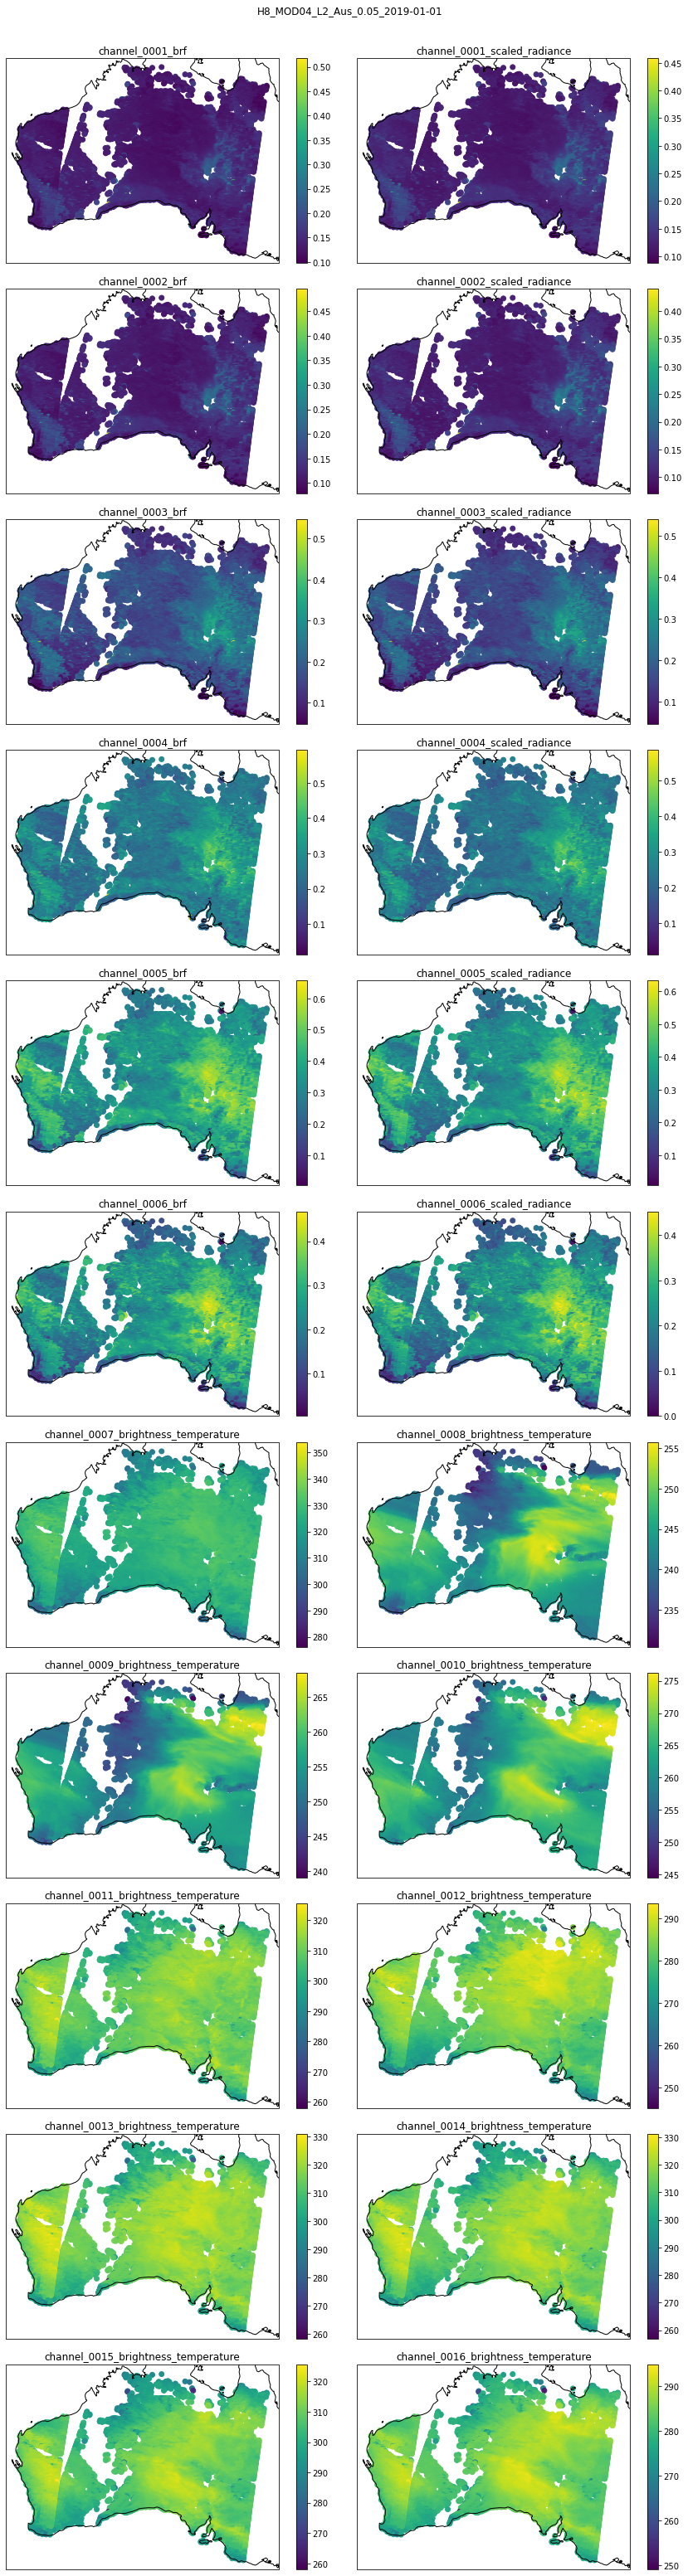

In [205]:
nc_path = '../../H8_MODIS_2019-2020/H8_MOD04_L2/H8_MOD04_L2_Aus_0.05_2019-01-01.nc'
nc = netCDF4.Dataset(nc_path)
for k in nc.variables.keys():
    print(k)
    
var_list = [k for k in nc.variables.keys() if k.startswith('channel')]

# fig, axs = plt.subplots(11,2,figsize=(12,44))
fig = plt.figure(figsize=(12,44))

for i, var in enumerate(var_list):
    row = i//2
    col = i%2
    # ax = axs[row, col]
    ax = plt.subplot(11, 2, i+1, projection=ccrs.PlateCarree())
    sc = ax.scatter(nc['lon'][:].data, nc['lat'][:].data, c=nc[var][:].data)
    ax.coastlines()
    fig.colorbar(sc, ax=ax)
    ax.set_title(var)
    
fig.suptitle('H8_MOD04_L2_Aus_0.05_2019-01-01')
fig.tight_layout()
fig.subplots_adjust(top=0.96)
# plt.savefig('test_h8')

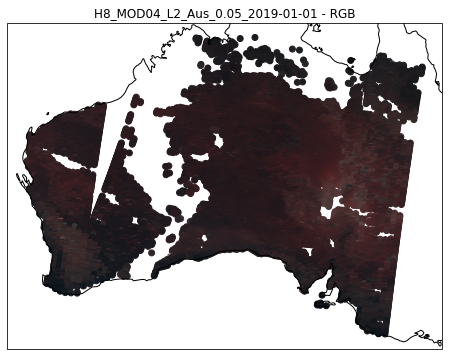

In [204]:
nc_path = '../../H8_MODIS_2019-2020/H8_MOD04_L2/H8_MOD04_L2_Aus_0.05_2019-01-01.nc'
nc = netCDF4.Dataset(nc_path)

b = nc['channel_0001_scaled_radiance'][:].data
g = nc['channel_0002_scaled_radiance'][:].data
r = nc['channel_0003_scaled_radiance'][:].data
# b = nc['channel_0001_brf'][:].data
# g = nc['channel_0002_brf'][:].data
# r = nc['channel_0003_brf'][:].data

rgb = np.stack([r,g,b], axis=1)

plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(nc['lon'][:].data, nc['lat'][:].data, c=rgb)
ax.coastlines()
ax.set_title('H8_MOD04_L2_Aus_0.05_2019-01-01 - RGB')
plt.show()

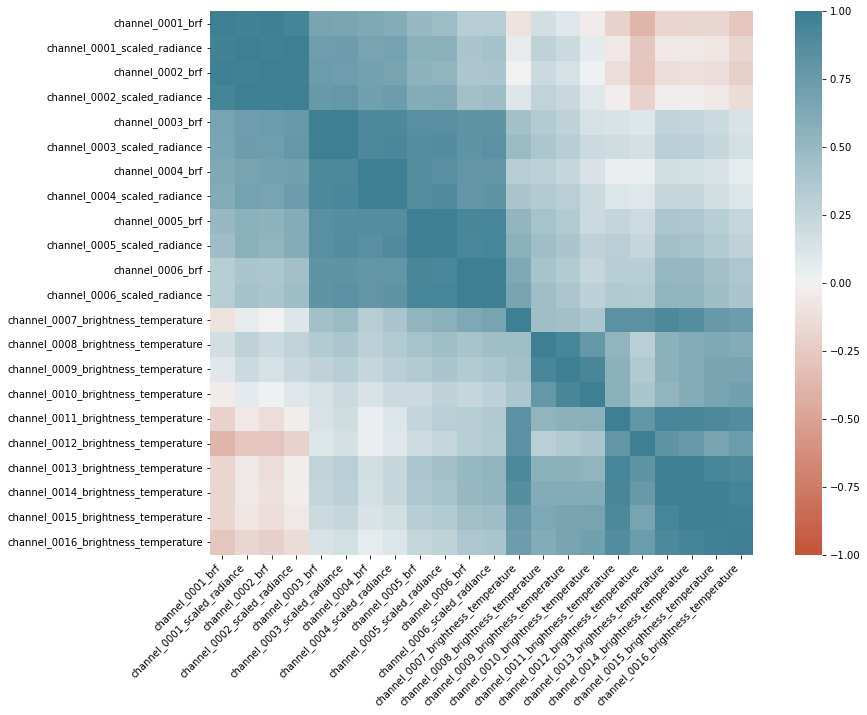

In [254]:
var_list = [k for k in nc.variables.keys() if k.startswith('channel')]
# var_list = [k for k in nc.variables.keys() if k.startswith('channel') and not k.endswith('_brf')]
corr = df[var_list].corr()
# sns.heatmap(corr, 
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values)
plt.figure(figsize=(15,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

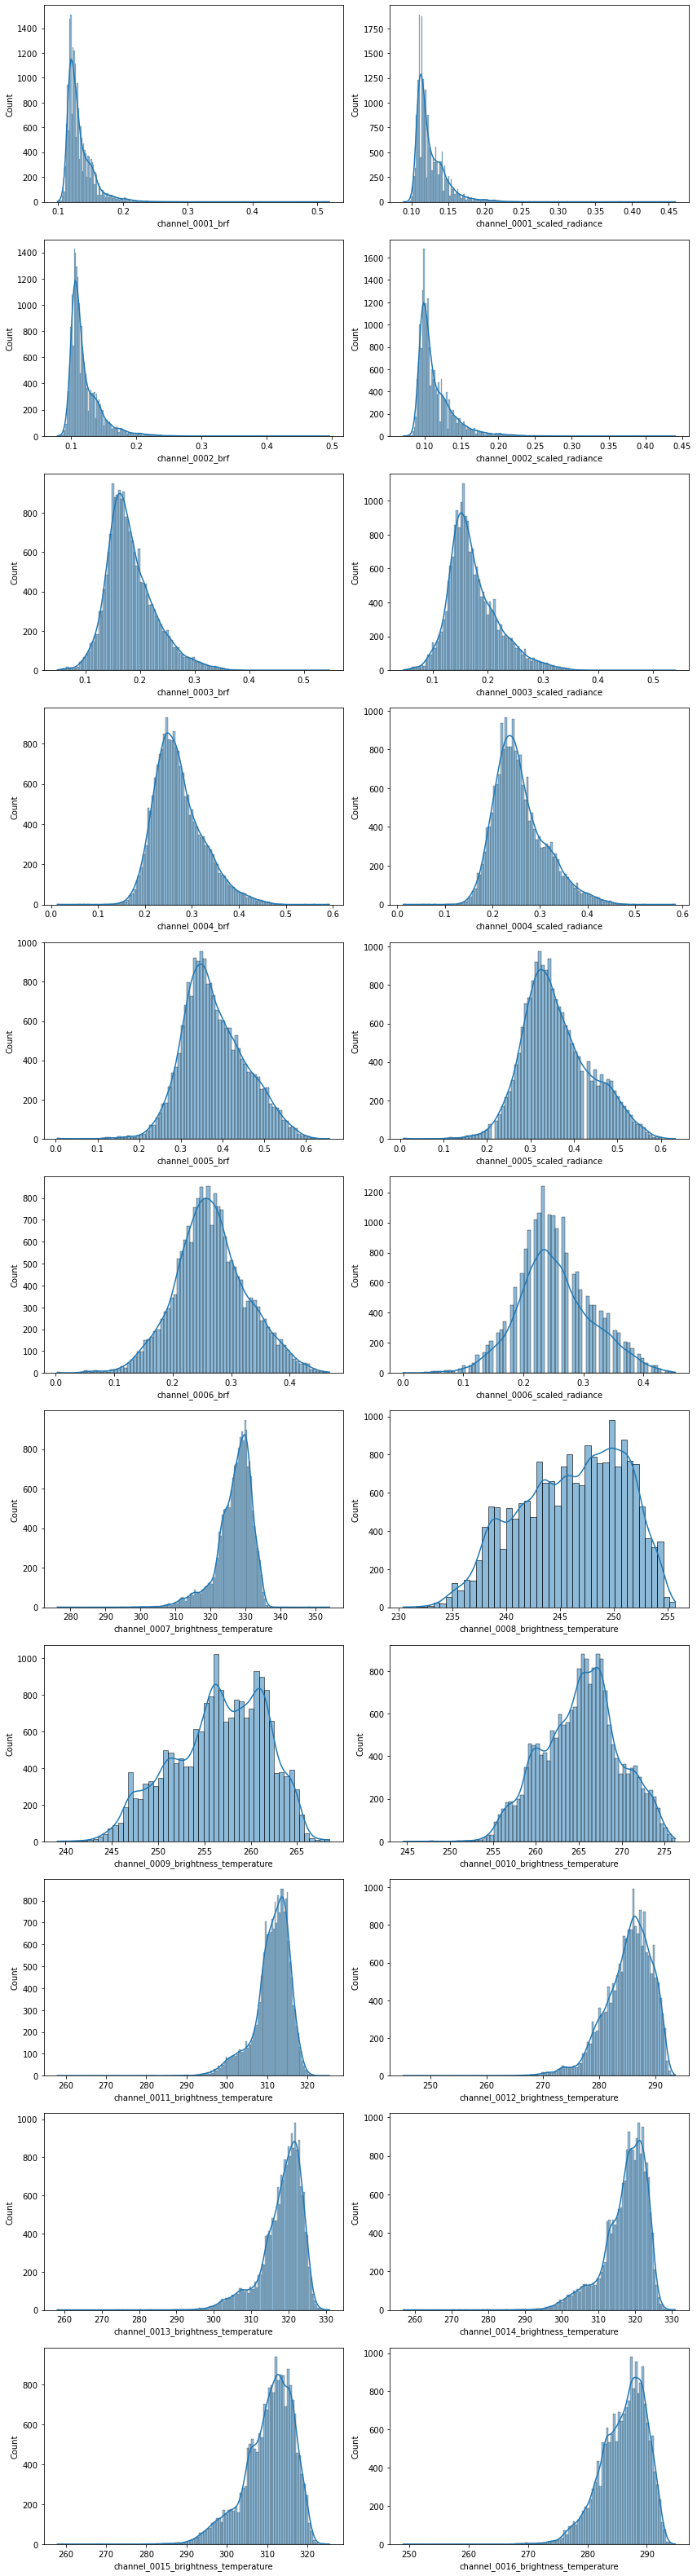

In [236]:
f, axs = plt.subplots(11, 2, figsize=(12,44))
var_list = [k for k in nc.variables.keys() if k.startswith('channel')]
for i, var in enumerate(var_list):
    row = i//2
    col = i%2
    sns.histplot(data=df, x=var, kde=True, ax=axs[row, col])
f.tight_layout()

# MODIS Terra - MOD04_L2

Solar_Zenith
Solar_Azimuth
Sensor_Zenith
Sensor_Azimuth
Land_sea_Flag
Aerosol_Type_Land
Longitude
Latitude
latitude_corner
longitude_corner
time
i_file
file
file_status
AOD_550_Dark_Target_Deep_Blue_Combined


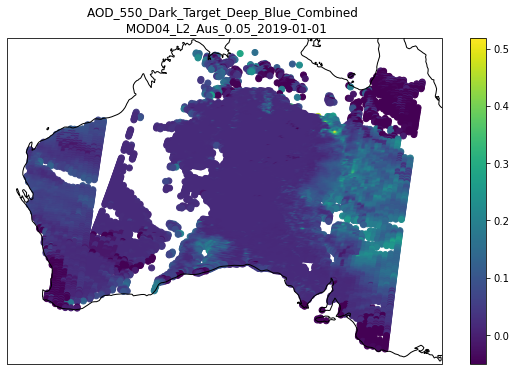

In [98]:
nc_path = '../../MODIS_L2_Aus_2019-2020/MOD04_L2_Aus_0.05_2019-01-01.nc'
nc = netCDF4.Dataset(nc_path)
for k in nc.variables.keys():
    print(k)
    
plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(nc['Longitude'][:].data, nc['Latitude'][:].data, c=nc['AOD_550_Dark_Target_Deep_Blue_Combined'][:].data)
plt.colorbar()
ax.coastlines()
ax.set_title('AOD_550_Dark_Target_Deep_Blue_Combined \n MOD04_L2_Aus_0.05_2019-01-01')
plt.show()

# MODIS Aqua - MYD04_L2

Solar_Zenith
Solar_Azimuth
Sensor_Zenith
Sensor_Azimuth
Land_sea_Flag
Aerosol_Type_Land
Longitude
Latitude
latitude_corner
longitude_corner
time
i_file
file
file_status
AOD_550_Dark_Target_Deep_Blue_Combined


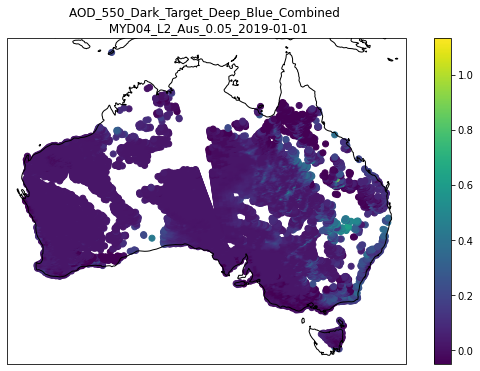

In [107]:
nc_path = '../../MODIS_L2_Aus_2019-2020/MYD04_L2_Aus_0.05_2019-01-01.nc'
nc = netCDF4.Dataset(nc_path)
for k in nc.variables.keys():
    print(k)
    
plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(nc['Longitude'][:].data, nc['Latitude'][:].data, c=nc['AOD_550_Dark_Target_Deep_Blue_Combined'][:].data)
plt.colorbar()
ax.coastlines()
plt.title('AOD_550_Dark_Target_Deep_Blue_Combined \n MYD04_L2_Aus_0.05_2019-01-01')
plt.show()

# VIIRS Deep Blue - AERDB_L2_VIIRS

Solar_Zenith_Angle
Viewing_Zenith_Angle
Relative_Azimuth_Angle
Longitude
Latitude
Aerosol_Type_Land_Ocean
Land_Ocean_Quality_Flag
Aerosol_Optical_Thickness_550_Land_Ocean_Best_Estimate
latitude_corner
longitude_corner
time
i_file
file
file_status


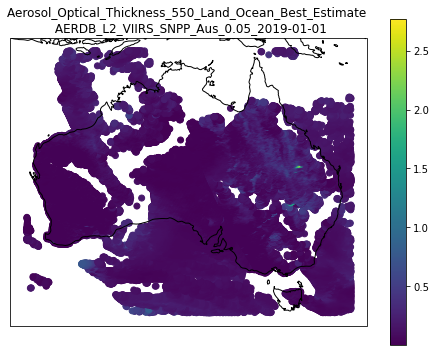

In [257]:
nc_path = '../../VIIRS_L2_Aus_2019-2020/AERDB_L2_VIIRS_SNPP_Aus_0.05_2019-01-01.nc'
nc = netCDF4.Dataset(nc_path)
for k in nc.variables.keys():
    print(k)
    
df = pd.DataFrame({'Latitude':nc['Latitude'][:].data, 
                   'Longitude':nc['Longitude'][:].data, 
                   'Aerosol_Optical_Thickness_550_Land_Ocean_Best_Estimate':nc['Aerosol_Optical_Thickness_550_Land_Ocean_Best_Estimate'][:].data})
df = df[df['Aerosol_Optical_Thickness_550_Land_Ocean_Best_Estimate']>=0]
    
plt.figure(figsize=(8,6)) 
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(df['Longitude'], df['Latitude'], c=df['Aerosol_Optical_Thickness_550_Land_Ocean_Best_Estimate'])
plt.colorbar()
ax.coastlines()
plt.title('Aerosol_Optical_Thickness_550_Land_Ocean_Best_Estimate \n AERDB_L2_VIIRS_SNPP_Aus_0.05_2019-01-01')
plt.show()

# VIIRS Dark Target - AERDT_L2_VIIRS

solar_zenith_angle
sensor_zenith_angle
sensor_azimuth_angle
longitude
latitude
Aerosol_Type_Land
Land_Sea_Flag
Land_Ocean_Quality_Flag
Image_Optical_Depth_Land_And_Ocean
latitude_corner
longitude_corner
time
i_file
file
file_status


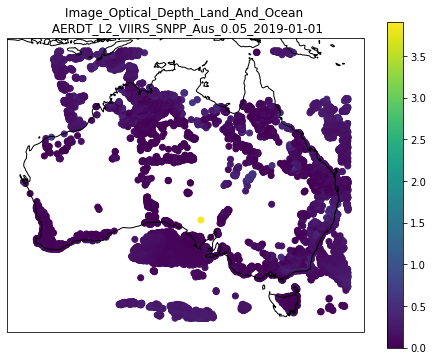

In [256]:
nc_path = '../../VIIRS_L2_Aus_2019-2020/AERDT_L2_VIIRS_SNPP_Aus_0.05_2019-01-01.nc'
nc = netCDF4.Dataset(nc_path)
for k in nc.variables.keys():
    print(k)
    
df = pd.DataFrame({'latitude':nc['latitude'][:].data, 
                   'longitude':nc['longitude'][:].data, 
                   'Image_Optical_Depth_Land_And_Ocean':nc['Image_Optical_Depth_Land_And_Ocean'][:].data})
df = df[df['Image_Optical_Depth_Land_And_Ocean']>=0]

plt.figure(figsize=(8,6)) 
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(df['longitude'], df['latitude'], c=df['Image_Optical_Depth_Land_And_Ocean'])
plt.colorbar()
ax.coastlines()
plt.title('Image_Optical_Depth_Land_And_Ocean \n AERDT_L2_VIIRS_SNPP_Aus_0.05_2019-01-01')
plt.show()